This notebook implements the class NMRsimulator, which contains a method to simulate the NMR spectrum of a spin system. After the classes definiton there is some examples of code defining a spin systema and plotting its spectrum with some explanation I wrote. This code have been developed by our colleage Gary Sharman.

I have added two new methods for the class NMRSimulator that allows the user to use its own eigenvalues and eigenvectors as the vals and vecs matrixes.

At the end you will find a 4 and 5 spin systems test cases.

In [1]:
import json
import random
import numpy as np
import pandas as pd

In [2]:
import numpy as np
from numpy import linalg as LA
from scipy.fft import fft
from scipy.linalg import expm
import time
import random
import math
from IPython.display import display

In [3]:
import matplotlib.pyplot as plt

In [4]:
class SpinSystem:
  def __init__(self):
    self.nucs = []
    self.jlist = []
    self.level =1
    
  def addNuc(self,name,shift):
      tn = nucleus(name,shift);
      self.nucs.append(tn)
      
  def addJ(self,name1,name2,j):
      tn = coupling(name1,name2,j);
      self.jlist.append(tn)
    
class nucleus:
    def __init__(self,name,shift):
      self.name = name
      self.shift = shift
      
class coupling:
    def __init__(self,name1,name2,j):
      self.name1 = name1
      self.name2=name2
      self.j = j

In [5]:
class NMRSimulator:
    E= np.matrix([[1, 0],[0, 1]])
    Ix = np.matrix([[0, 1/2],[1/2, 0]])
    Iy= np.matrix([[0, -1J/2], [1J/2, 0]])
    Iz = np.matrix([[1/2,0],[0,-1/2]])   
      
    def __init__(self):
      #std operators        
  

      # SET SIM parameters here
      self.field =400   
      self.swp = 10
      self.setOffsetPPM( 5)
      self.setTD(2**14)
      self.setT2(2);
      self.debug=False
      #self.noise=1/2000
      self.nucleus="1H"
      
    def setField(self,field):
        self.field=field
        self.offsetH = self.offset*self.field
        
    def setSWPPM(self,swp): 
        self.swp=swp
        self.swh=swp*self.field
        self.dw=1/self.swh
        
    def setOffsetPPM(self,offset):
        self.offset=offset
        self.offsetH = self.offset*self.field
        
    def setTD(self,td):
        self.td=int(td)
        
    def setT2(self, t2):
        self.t2=t2
      
    def getOperator (op, n):
        for i in range(n):
            if i==0:
                h=op
            else:
                h=NMRSimulator.E
            for j in range (1,n):
                if i==j:
                    h2=op
                else:
                    h2=NMRSimulator.E
                h=np.kron(h,h2)
            if(i==0):
                H=h
            else:
                H=H+h
        return H;
    
      
    def makeHamiltonian(self, ss):
        for n in ss.nucs:
            ind = ss.nucs.index(n)
            #print('nuc ' + n.name + ' ' +  str(ind))
            if ind==0:
                h=NMRSimulator.Iz
            else:
                h=NMRSimulator.E
            for i in range (1,len(ss.nucs)):
                if ind==i:
                    h2=NMRSimulator.Iz
                else:
                    h2=NMRSimulator.E
                h=np.kron(h,h2)
            h = h * np.pi*2 * (n.shift * self.field - self.offsetH)
            if(ind==0):
                H=h
            else:
                H=H+h
            
        #print('done nucs')
        for j in ss.jlist:
            ind1 = NMRSimulator.getIndexForName(j.name1, ss.nucs)
            ind2 = NMRSimulator.getIndexForName(j.name2, ss.nucs)
            #print (str(ind1) + '   ' + str(ind2))
            if ind1==0 or ind2==0:
                hx=NMRSimulator.Ix
                hy=NMRSimulator.Iy
                hz=NMRSimulator.Iz
                #print('ind0 hx')
            else:
                hx=NMRSimulator.E
                hy=NMRSimulator.E
                hz=NMRSimulator.E
                #print('ind0 E')
            for i in range (1,len(ss.nucs)):
                if ind1==i or ind2==i:
                    hx2=NMRSimulator.Ix
                    hy2=NMRSimulator.Iy
                    hz2=NMRSimulator.Iz
                    #print('indi hx')
                else:
                    hx2=NMRSimulator.E
                    hy2=NMRSimulator.E
                    hz2=NMRSimulator.E
                    #print('indi E')
                hx=np.kron(hx,hx2)
                hy=np.kron(hy,hy2)
                hz=np.kron(hz,hz2)
            H= H + 2*np.pi*j.j*(hx + hy + hz)
        return H

    def getIndexForName(name, nucs):
        for l in nucs:
            ind = nucs.index(l)
            if(l.name == name):
                return ind;
        

        
    def simSpinSystem(self, ss):
        H = self.makeHamiltonian(ss)
        m0 = NMRSimulator.getOperator(NMRSimulator.Ix,len(ss.nucs))
        IxT = m0
        IyT = NMRSimulator.getOperator(NMRSimulator.Iy,len(ss.nucs))
        vals,vecs = LA.eigh(H)
        vecsi = LA.inv(vecs)
        diag = np.diag(vals)
        fidr  = np.empty(self.td);
        fidi  = np.empty(self.td);
        t = np.empty(self.td);
        ff = self.t2/(2*np.pi)
        fac = ss.level / 2**len(ss.nucs)    
        mMat = vecsi * m0 * vecs
        if(self.debug):
            print('made matrices ' + str(time.process_time() - self.start))
        for x in range (self.td):
            t[x]=x*self.dw
            tm = vecs * expm(-1J*t[x]*diag) * mMat * expm(1J*t[x]*diag) * vecsi
            fac2 =  np.exp(-x*self.dw/ff) * fac
            fidr[x] = np.trace(tm*IxT) * fac2
            fidi[x] = np.trace(tm*IyT) * fac2
        if(self.debug):
            print('made fid ' + str(time.process_time() - self.start))
        return fidr,fidi,tm, vals, vecs
    
    def simSpinSystemQuantum(self, ss, vals, vecs):
        H = self.makeHamiltonian(ss)
        m0 = NMRSimulator.getOperator(NMRSimulator.Ix,len(ss.nucs))
        IxT = m0
        IyT = NMRSimulator.getOperator(NMRSimulator.Iy,len(ss.nucs))
        vecsi = LA.inv(vecs)
        diag = np.diag(vals)
        fidr  = np.empty(self.td);
        fidi  = np.empty(self.td);
        t = np.empty(self.td);
        ff = self.t2/(2*np.pi)
        fac = ss.level / 2**len(ss.nucs)    
        mMat = vecsi * m0 * vecs
        if(self.debug):
            print('made matrices ' + str(time.process_time() - self.start))
        for x in range (self.td):
            t[x]=x*self.dw
            tm = vecs * expm(-1J*t[x]*diag) * mMat * expm(1J*t[x]*diag) * vecsi
            fac2 =  np.exp(-x*self.dw/ff) * fac
            fidr[x] = np.trace(tm*IxT) * fac2
            fidi[x] = np.trace(tm*IyT) * fac2
        if(self.debug):
            print('made fid ' + str(time.process_time() - self.start))
        return fidr,fidi,tm, vals, vecs
    
#    def getNoise(self):
#        u = random.random(); 
#        v = random.random();
#        return math.sqrt(-2.0 * math.log(u)) * math.cos(2.0 * np.pi * v) * self.noise;
#    
#    def addNoise(self,re,im):
#        for i in range(len(re)):
#            re[i]=re[i]+self.getNoise()
#            im[i]=im[i]+self.getNoise()

    def simSpectrum(self, sss, sc=1.0, b=0.0):

        fidrSum  = np.zeros(self.td);
        fidiSum  = np.zeros(self.td);
        self.start = time.process_time()
        for ss in sss: 
            fidr,fidi,tm, vals, vecs = self.simSpinSystem(ss)
            fidrSum = fidr + fidrSum
            fidiSum = fidi + fidiSum
        
        fidrSum  = fidrSum * sc 
        fidiSum = fidiSum * sc
        
        #self.addNoise(fidrSum,fidiSum)
        spcr = fft(fidrSum)
        spci = fft(fidiSum)
        if(self.debug):
            print('done fft ' + str(time.process_time() - self.start))
        spc = spcr-1J*spci
        spcOut = np.empty(self.td);
        fs = np.empty(self.td);
        td2 =int(self.td/2)
        for i in range(td2):
            spcOut[td2+i]=spc[i]
            spcOut[i] = spc[td2+i]
            fs[i] = (1/self.dw/2 - i/td2/self.dw/2)/self.field + self.offset
            fs[self.td-i-1]=(-1/self.dw/2 + i/td2/self.dw/2) / self.field + self.offset
        if(self.debug):
            print('all done ' + str(time.process_time() - self.start))
        spcOut = spcOut - np.amin(spcOut)
        spcOut = spcOut + b
        return spcOut,fs, vals, vecs
    
    def simSpectrumQuantum(self, sss, vals, vecs, sc=1.0, b=0.0):

        fidrSum  = np.zeros(self.td);
        fidiSum  = np.zeros(self.td);
        self.start = time.process_time()
        for ss in sss: 
            fidr,fidi,tm, vals, vecs = self.simSpinSystemQuantum(ss, vals, vecs)
            fidrSum = fidr + fidrSum
            fidiSum = fidi + fidiSum
        
        fidrSum  = fidrSum * sc 
        fidiSum = fidiSum * sc
        
        #self.addNoise(fidrSum,fidiSum)
        spcr = fft(fidrSum)
        spci = fft(fidiSum)
        if(self.debug):
            print('done fft ' + str(time.process_time() - self.start))
        spc = spcr-1J*spci
        spcOut = np.empty(self.td);
        fs = np.empty(self.td);
        td2 =int(self.td/2)
        for i in range(td2):
            spcOut[td2+i]=spc[i]
            spcOut[i] = spc[td2+i]
            fs[i] = (1/self.dw/2 - i/td2/self.dw/2)/self.field + self.offset
            fs[self.td-i-1]=(-1/self.dw/2 + i/td2/self.dw/2) / self.field + self.offset
        if(self.debug):
            print('all done ' + str(time.process_time() - self.start))
        spcOut = spcOut - np.amin(spcOut)
        spcOut = spcOut + b
        return spcOut,fs, vals, vecs

First, we need to define our spin system. Create and object SpinSystem and then add the nuclei and J couplings with the corresponding methods addNuc and addJ. The function addNuc takes as arguments a label for the spin and the chemical shift value (in ppm units). The addJ takes two labels corresponding to the spins coupled and the J value (Hz).

Then we instatiate the class NMRSimulator. nmrsim is our object which mimics an experimental spectrometer. The various methods of this class set different characteristic of our experiment. setField to input the working frequency of our spectrometer. You can use 400 (MHz). setTD is the number of points of the spectrum. Mnova uses additional algorithm to reconstruct the spectrum, so with less points the result is cleaner than the output of this program. You will notices how the time increases if you select larger amounts of points. If you use too little points the spectrum will be very poor. The spectrum plotted in our archive document used 2^19 points. setSWPPM sets the range of ppm the spectrun will have. By default we use 10, if any shift is larger than 10 the spectral width must be increased accordingly. setOffsetPPM is self-explanatory, we should agree to use always 5. Same for setT2, please always use 2, as deduced from the code this value is related to some rescalation related to the spectral width.


To simulate our spectrum we need to call the method simSpectrum of the class NMRSimulator. This method takes as argument a list of the spin system to simulate, so once you define your spin system added to a list. For example I have defined my spin system named sscase and added to a list named sss. Of course you could just pass as argument [sscase] and it will work. If you are curious about this decision, this is becase when studiying a molecule we may group its nuclei in more than one spin system, but for the scope of this project we will always consider one solely spin system.

In [6]:
sscase = SpinSystem()
sscase.addNuc('a', 1)
sscase.addNuc('b', 2)
sscase.addJ('a', 'b', 50)
sscase.level=1
nmrsim = NMRSimulator()
nmrsim.setField(400)
nmrsim.setTD(32000)
nmrsim.setSWPPM(10)
nmrsim.setOffsetPPM(5)
nmrsim.setT2(2.0)
sslist = []
sslist.append(sscase)

The output of the call to simSpectrum is:

-> spcOut: and array containing the values of intensity. Originally these array contains complex numbers. As you can read in the warning message, the complex part is discarded. This is because tipically we plot the real part only, although for some purposes we may be interested to plot the imaginary part. (The FID signal does have a real and complex part too as you can guess from reading the code defininf the classes).
-> fs is the collection of points of the x axis, the ppm frequencies
-> v,w are the eigenvalues and eigenvectores retrieved from a call to numpy.linalg.eigh (here numpy.linalg is import as LA)

In [7]:
spcOut, fs, v, w= nmrsim.simSpectrum([sscase])

C:\Users\AlexandreRodriguez\AppData\Local\Temp\ipykernel_26688\904100246.py:139: ComplexWarning: Casting complex values to real discards the imaginary part
  fidr[x] = np.trace(tm*IxT) * fac2
C:\Users\AlexandreRodriguez\AppData\Local\Temp\ipykernel_26688\904100246.py:140: ComplexWarning: Casting complex values to real discards the imaginary part
  fidi[x] = np.trace(tm*IyT) * fac2
C:\Users\AlexandreRodriguez\AppData\Local\Temp\ipykernel_26688\904100246.py:203: ComplexWarning: Casting complex values to real discards the imaginary part
  spcOut[td2+i]=spc[i]
C:\Users\AlexandreRodriguez\AppData\Local\Temp\ipykernel_26688\904100246.py:204: ComplexWarning: Casting complex values to real discards the imaginary part
  spcOut[i] = spc[td2+i]


You can plot the spectrum remember fs is the array for the x axis and spcout for the y axis. By convention, in NMR we plot the frequencies from left to right, i.e., higher frequencies are ploted in the rightmost part of the x axis. Play with xlim values to plot a certain part of the spectrum. Normally the regions of interest are centered around the chemical shifts you used as input.

(2.15, 0.9)

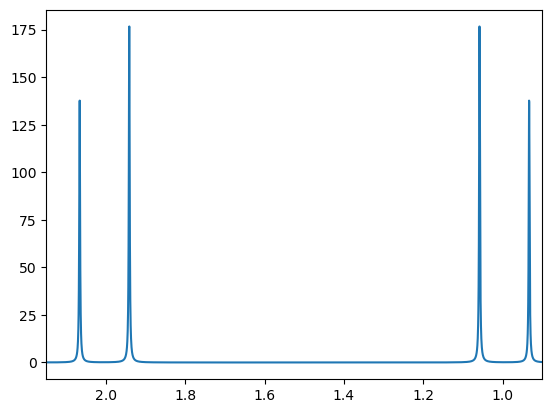

In [8]:
plt.plot(fs, spcOut, '-')
plt.xlim(2.15,0.9)

(2.15, 1.8)

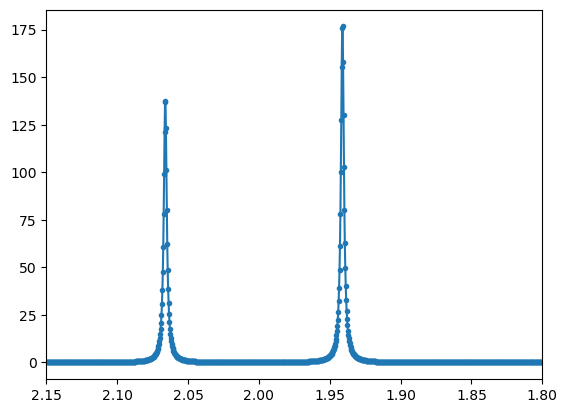

In [9]:
plt.plot(fs, spcOut, '.-')
plt.xlim(2.15,1.8)

I attach the spectrum plotted by Mnova here. The intensities are in different scales so do not pay attention to them. The important thing to pay attention to is the position of the peaks and the relative intensity. For example in this test case there should four peaks grouped in two pairs (we call it doublets). In each doublet, the outer peak is smaller than the other one. Of course, if we want to be truly rigurous we can compare mathematically two spectrum.

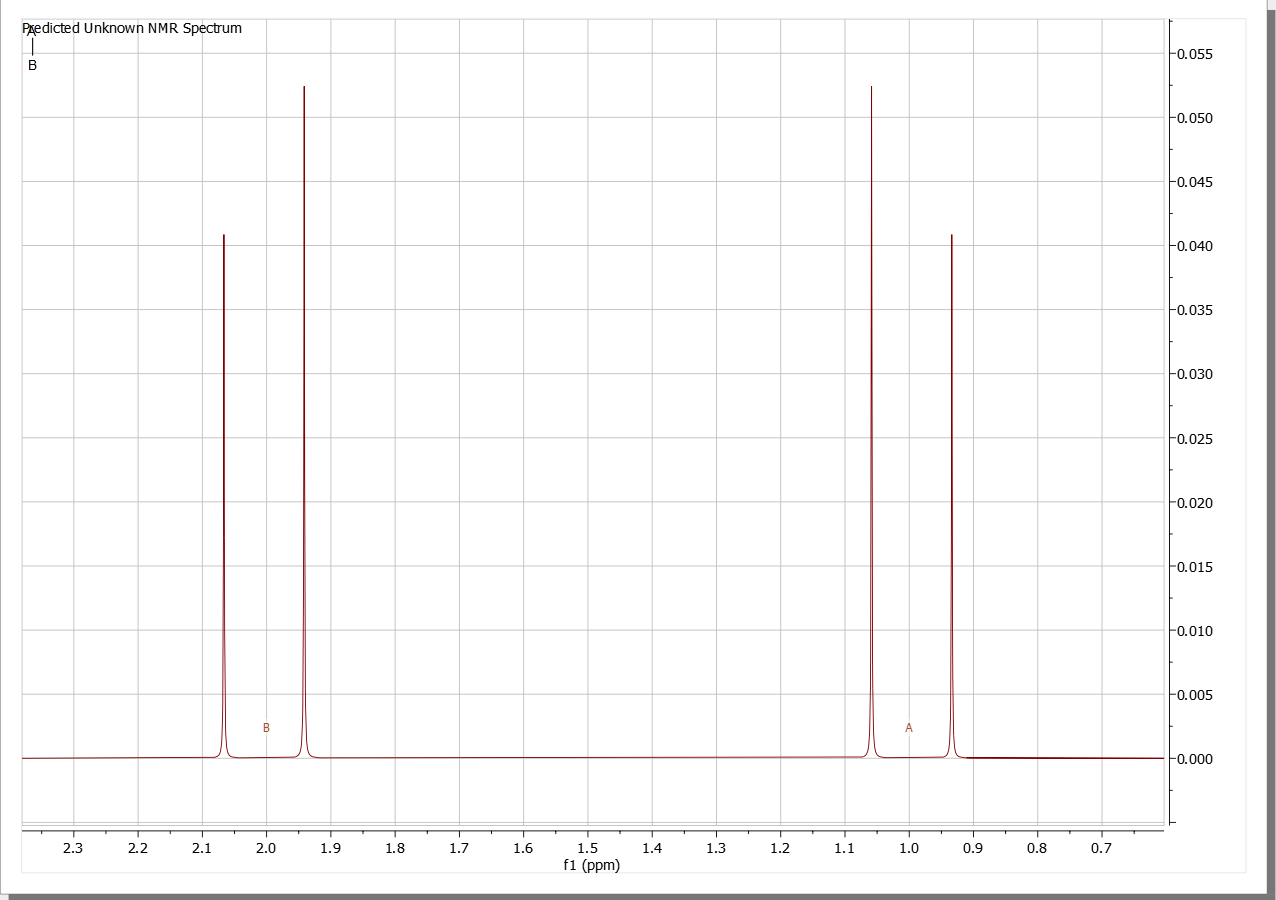

Now suppose, you have built youself the matrixes with the eigenvalues and eigenvectors and want to use them to simulate the spectrum. Here I have the Hamiltonian associated with the spin system I have just simulated. You would create the spin system just and the same NMRsimulator. But now, you may call simSpectrumQuantum and pass as additional arguments your own vals and vecs matrixes. Notice that in the matrix of eigenvectors each column is an eigenvector.

In [10]:
hamiltonian = np.array([[-8717.91961371+0.j,     0.        +0.j,     0.        +0.j,
            0.        +0.j],
       [    0.        +0.j, -1335.17687778+0.j,   157.07963268+0.j,
            0.        +0.j],
       [    0.        +0.j,   157.07963268+0.j,  1178.0972451 +0.j,
            0.        +0.j],
       [    0.        +0.j,     0.        +0.j,     0.        +0.j,
         8874.99924639+0.j]])

In [11]:
pd.DataFrame(LA.eigh(hamiltonian)[1])

,0,1,2,3
0,1.0+0.0j,0.000000+0.000000j,-0.000000-0.000000j,0.0+0.0j
1,0.0+0.0j,-0.998068+0.000000j,-0.062137-0.000000j,0.0+0.0j
2,0.0+0.0j,0.062137+0.000000j,-0.998068-0.000000j,0.0+0.0j
3,0.0+0.0j,0.000000+0.000000j,-0.000000-0.000000j,1.0+0.0j


In [12]:
sscase = SpinSystem()
sscase.addNuc('a', 1)
sscase.addNuc('b', 2)
sscase.addJ('a', 'b', 50)
sscase.level=1
nmrsim = NMRSimulator()
nmrsim.setField(400)
nmrsim.setTD(2**19)
nmrsim.setSWPPM(10)
nmrsim.setOffsetPPM(5)
nmrsim.setT2(2.0)
sss = []
sss.append(sscase)

In [13]:
spcOut, fs, v, w= nmrsim.simSpectrumQuantum(sss, LA.eigh(hamiltonian)[0], LA.eigh(hamiltonian)[1])

C:\Users\AlexandreRodriguez\AppData\Local\Temp\ipykernel_26688\904100246.py:164: ComplexWarning: Casting complex values to real discards the imaginary part
  fidr[x] = np.trace(tm*IxT) * fac2
C:\Users\AlexandreRodriguez\AppData\Local\Temp\ipykernel_26688\904100246.py:165: ComplexWarning: Casting complex values to real discards the imaginary part
  fidi[x] = np.trace(tm*IyT) * fac2
C:\Users\AlexandreRodriguez\AppData\Local\Temp\ipykernel_26688\904100246.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  spcOut[td2+i]=spc[i]
C:\Users\AlexandreRodriguez\AppData\Local\Temp\ipykernel_26688\904100246.py:237: ComplexWarning: Casting complex values to real discards the imaginary part
  spcOut[i] = spc[td2+i]


Text(0.5, 1.0, 'QUANTUM SIMULATION')

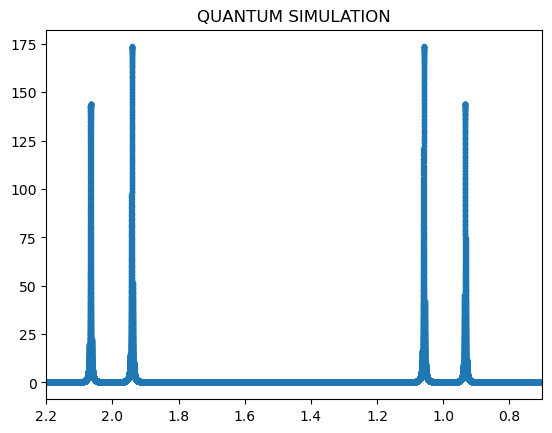

In [14]:
plt.plot(fs, spcOut, '.-')
plt.xlim(2.2,0.7)
plt.title('QUANTUM SIMULATION')

Here I define a system with 3 spins. You can see how the addJ logic works. In Mnova we visualize the coupings with a table. 
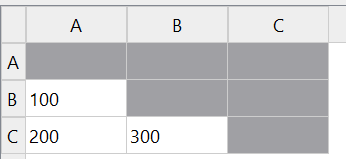
In my implementation of a function to build the Hamiltonian of a spin system I pass all the j couplings in a single array. In that array the J are ordered "alphabetically" or if you look at the table, I write all the columns from top to botton and from left to right. Actually, some weeks ago I defined a class testcase to better encapsulated the definition of a spin system in my works (you can find it in the next cell but as you see it needs the context of the notebook spinSystemHamiltonian I shared so do not run it here). So, if you wanted to define this spin system with my other class / function the jlist array will be [100,200,300]

In [15]:
sscase3 = SpinSystem()
sscase3.addNuc('a', 1)
sscase3.addNuc('b', 2)
sscase3.addNuc('c', 3)
sscase3.addJ('a', 'b', 100)
sscase3.addJ('a', 'c', 200)
sscase3.addJ('b','c', 300)
sscase3.level=1
nmrsim = NMRSimulator()
nmrsim.setField(400)
nmrsim.setTD(32000)
nmrsim.setSWPPM(10)
nmrsim.setOffsetPPM(5)
nmrsim.setT2(2.0)

In [16]:
spcOut, fs, v, w= nmrsim.simSpectrum([sscase3])

C:\Users\AlexandreRodriguez\AppData\Local\Temp\ipykernel_26688\904100246.py:139: ComplexWarning: Casting complex values to real discards the imaginary part
  fidr[x] = np.trace(tm*IxT) * fac2
C:\Users\AlexandreRodriguez\AppData\Local\Temp\ipykernel_26688\904100246.py:140: ComplexWarning: Casting complex values to real discards the imaginary part
  fidi[x] = np.trace(tm*IyT) * fac2
C:\Users\AlexandreRodriguez\AppData\Local\Temp\ipykernel_26688\904100246.py:203: ComplexWarning: Casting complex values to real discards the imaginary part
  spcOut[td2+i]=spc[i]
C:\Users\AlexandreRodriguez\AppData\Local\Temp\ipykernel_26688\904100246.py:204: ComplexWarning: Casting complex values to real discards the imaginary part
  spcOut[i] = spc[td2+i]


(2.0, 0.3)

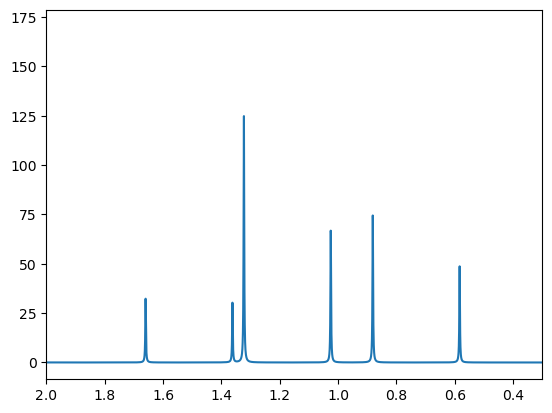

In [17]:
plt.plot(fs, spcOut, '-')
plt.xlim(2,0.3)

# 4 and 5 spins system

In this section I described an example of a 4 and 5 spin system.

## AMPX System

This system consists of 4 spins. The ouput spectrum has four multiplets. You can see the the shifts and j values in the tables of the widget in the screenshot. I also defined in the next cell the arrays you can copy to work with. If you want to compare simulated spectra, you can compare the simulation output of the code of this jupyter with the vals and vecs from the linalg calculation and with the ones obtained by quantum simulation.

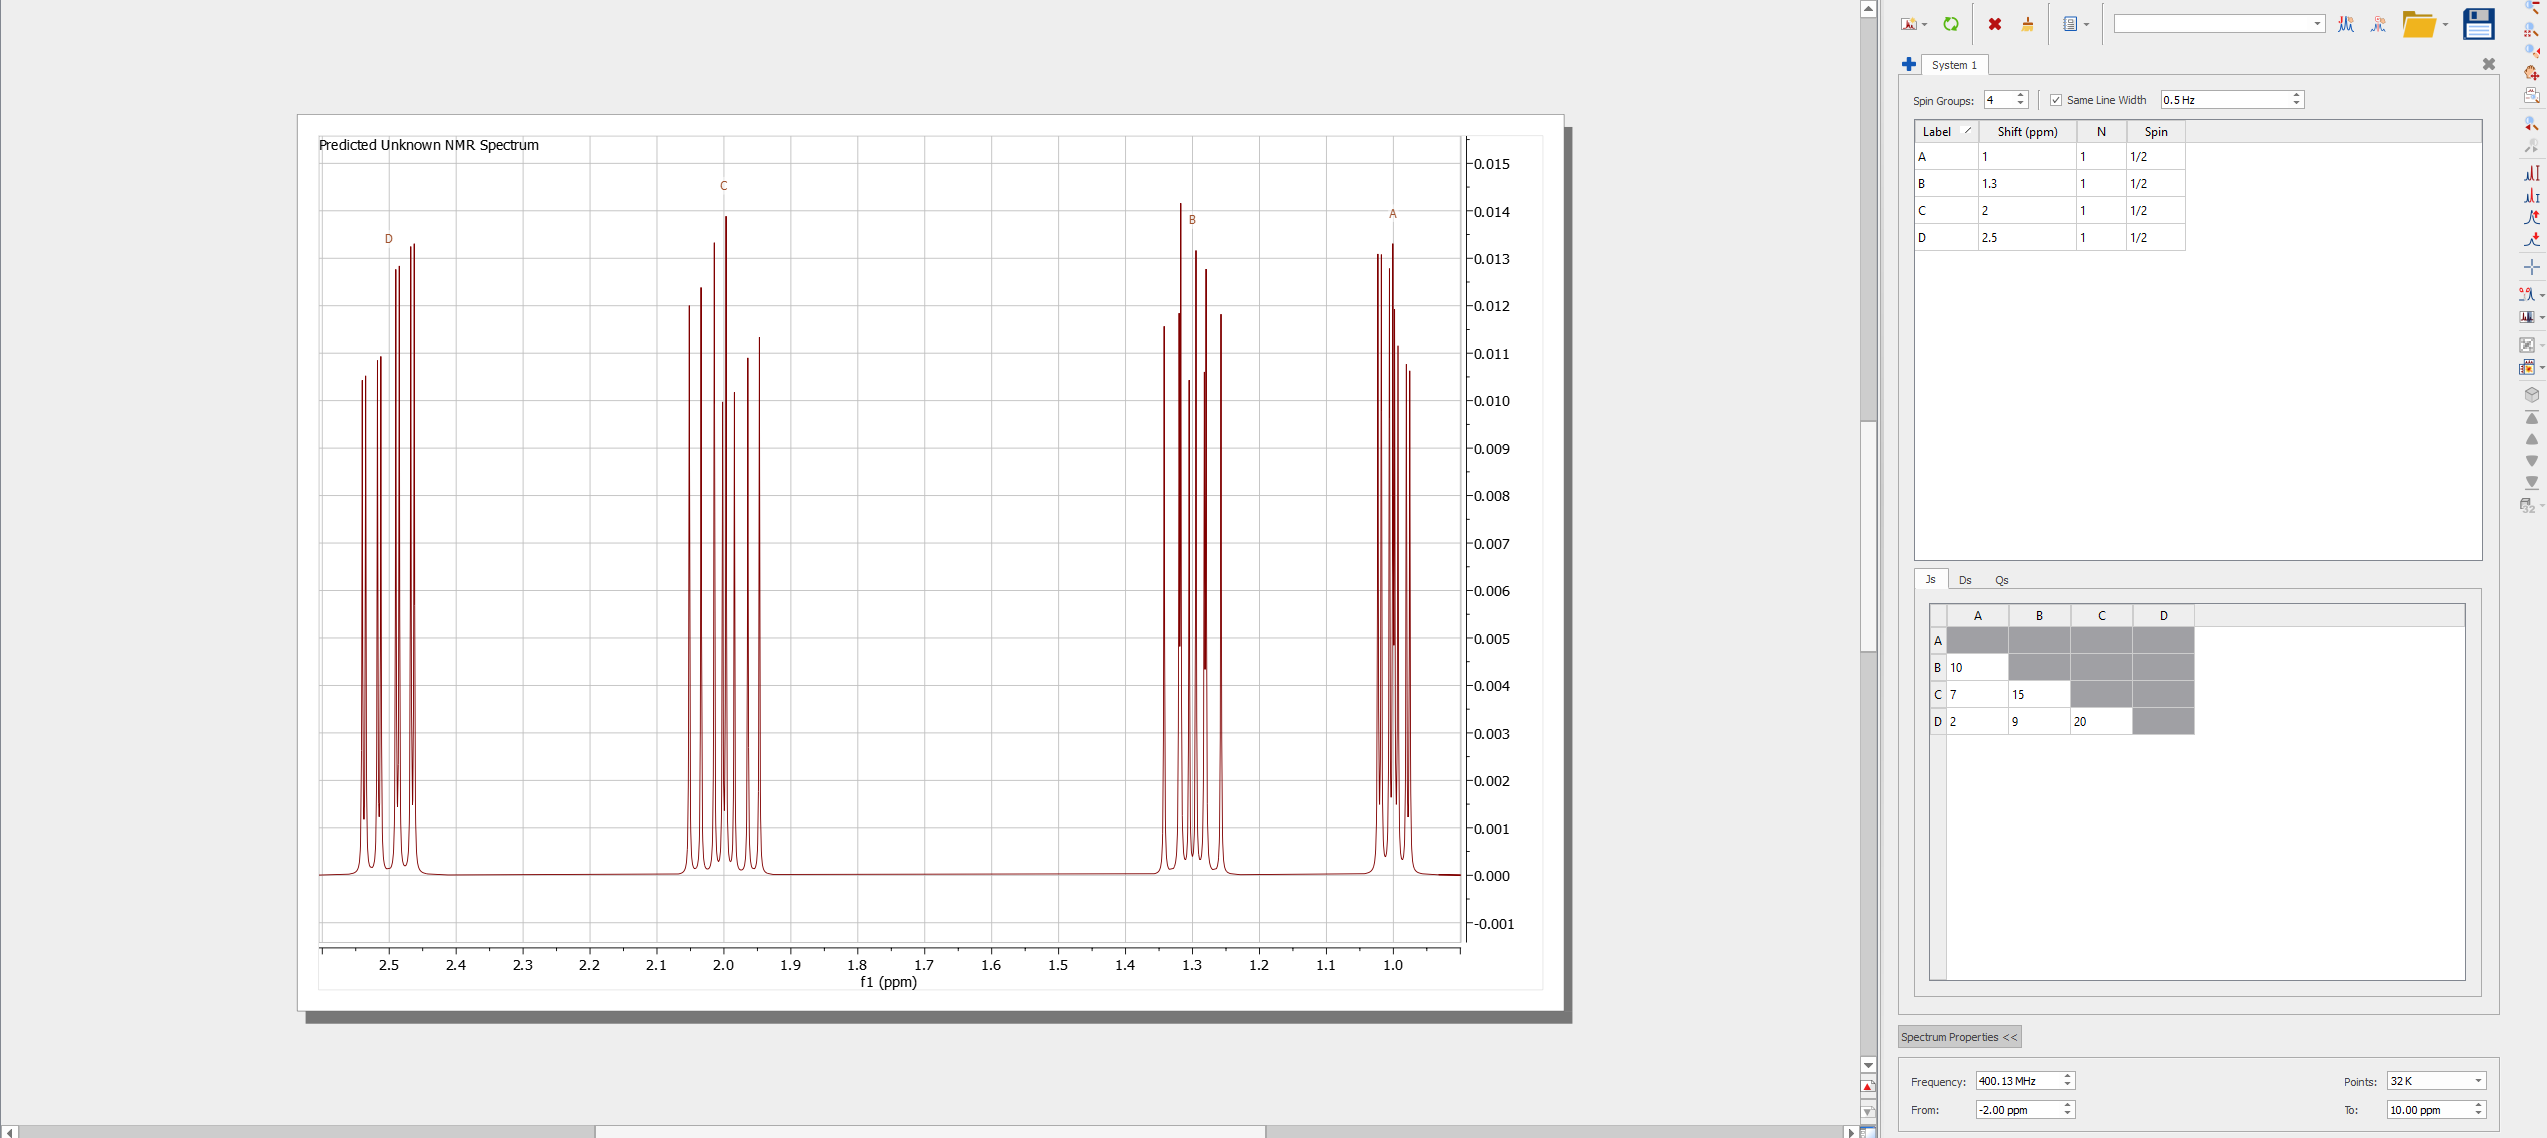

In [18]:
shifts = np.array([1,1.3,2,2.5])
j = np.array([10,7,2,15,9,20])

In [19]:
sscase4 = SpinSystem()
sscase4.addNuc('a', 1)
sscase4.addNuc('b', 1.3)
sscase4.addNuc('c', 2)
sscase4.addNuc('d', 2.5)
sscase4.addJ('a', 'b', 10)
sscase4.addJ('a', 'c', 7)
sscase4.addJ('a','d', 2)
sscase4.addJ('b', 'c', 15)
sscase4.addJ('b', 'd', 9)
sscase4.addJ('c', 'd', 20)
sscase4.level=1
nmrsim = NMRSimulator()
nmrsim.setField(400)
nmrsim.setTD(2**19)
nmrsim.setSWPPM(10)
nmrsim.setOffsetPPM(0)
nmrsim.setT2(2.0)

In [20]:
spcOut, fs, v, w= nmrsim.simSpectrum([sscase4])

C:\Users\AlexandreRodriguez\AppData\Local\Temp\ipykernel_26688\904100246.py:139: ComplexWarning: Casting complex values to real discards the imaginary part
  fidr[x] = np.trace(tm*IxT) * fac2
C:\Users\AlexandreRodriguez\AppData\Local\Temp\ipykernel_26688\904100246.py:140: ComplexWarning: Casting complex values to real discards the imaginary part
  fidi[x] = np.trace(tm*IyT) * fac2
C:\Users\AlexandreRodriguez\AppData\Local\Temp\ipykernel_26688\904100246.py:203: ComplexWarning: Casting complex values to real discards the imaginary part
  spcOut[td2+i]=spc[i]
C:\Users\AlexandreRodriguez\AppData\Local\Temp\ipykernel_26688\904100246.py:204: ComplexWarning: Casting complex values to real discards the imaginary part
  spcOut[i] = spc[td2+i]


(2.6, 0.9)

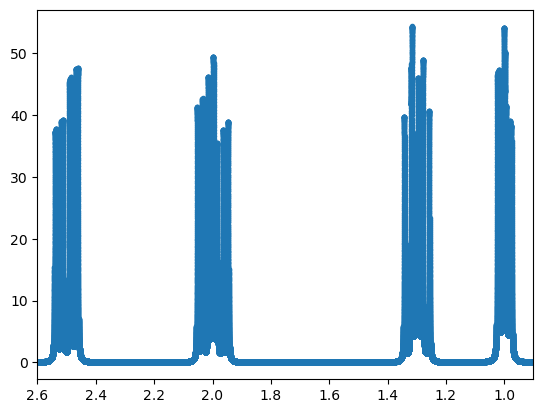

In [21]:
plt.plot(fs, spcOut, '.-')
plt.xlim(2.6,0.9)

If we zoom in the region (1.31,1.275) we see:

(1.31, 1.275)

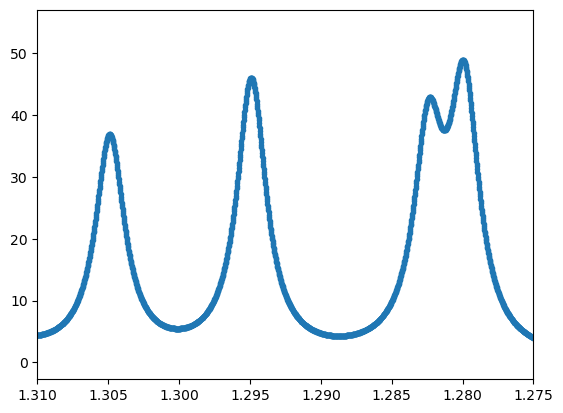

In [22]:
plt.plot(fs, spcOut, '.-')
plt.xlim(1.31,1.275)

## AA'MM'X

Here it is a 5 spin systems.

In [23]:
shifts5 = np.array([5,5,5.4,5.4,6])
j5 = np.array([100,20,25,5,35,30,9,200,40,45])

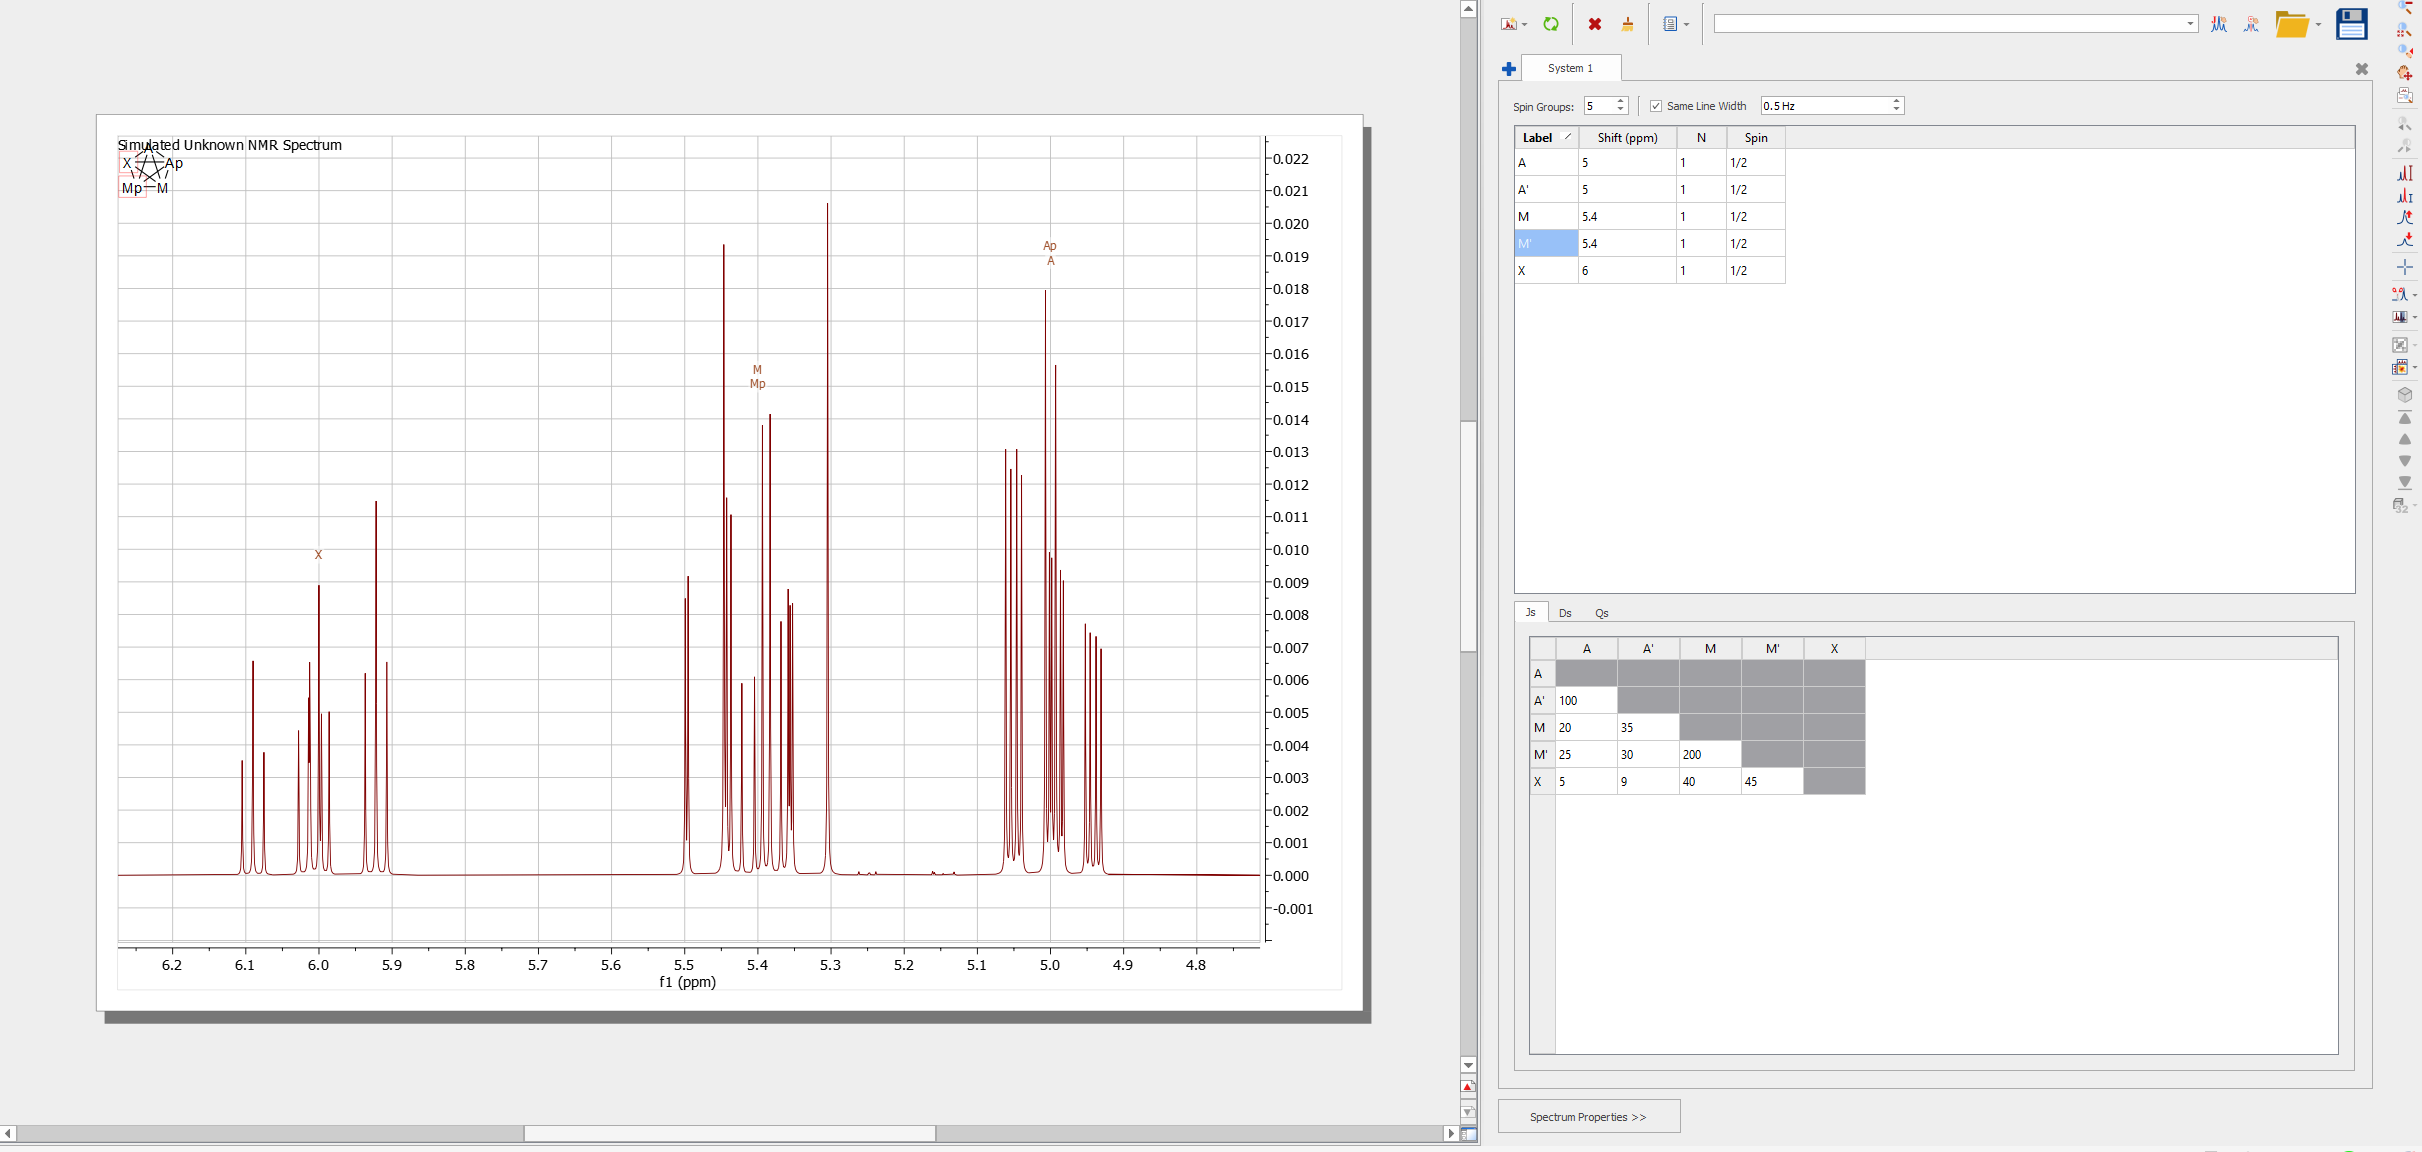

In [24]:
spincase5 = SpinSystem()
spincase5.addNuc('a', 5)
spincase5.addNuc('ap', 5)
spincase5.addNuc('m', 5.4)
spincase5.addNuc('mp', 5.4)
spincase5.addNuc('x', 6)
spincase5.addJ('a', 'ap', 100)
spincase5.addJ('a', 'm', 20)
spincase5.addJ('a','mp', 25)
spincase5.addJ('a', 'x', 5)
spincase5.addJ('ap', 'm', 35)
spincase5.addJ('ap', 'mp', 30)
spincase5.addJ('ap', 'x', 9)
spincase5.addJ('m', 'mp', 200)
spincase5.addJ('m', 'x', 40)
spincase5.addJ('mp','x', 45)
spincase5.level=1
nmrsim = NMRSimulator()
nmrsim.setField(400)
nmrsim.setTD(2**14)
nmrsim.setSWPPM(14)
nmrsim.setOffsetPPM(5)
nmrsim.setT2(2.0)
sss = []
sss.append(spincase5)

In [25]:
spcOut, fs, v, w= nmrsim.simSpectrum([spincase5])

C:\Users\AlexandreRodriguez\AppData\Local\Temp\ipykernel_26688\904100246.py:139: ComplexWarning: Casting complex values to real discards the imaginary part
  fidr[x] = np.trace(tm*IxT) * fac2
C:\Users\AlexandreRodriguez\AppData\Local\Temp\ipykernel_26688\904100246.py:140: ComplexWarning: Casting complex values to real discards the imaginary part
  fidi[x] = np.trace(tm*IyT) * fac2
C:\Users\AlexandreRodriguez\AppData\Local\Temp\ipykernel_26688\904100246.py:203: ComplexWarning: Casting complex values to real discards the imaginary part
  spcOut[td2+i]=spc[i]
C:\Users\AlexandreRodriguez\AppData\Local\Temp\ipykernel_26688\904100246.py:204: ComplexWarning: Casting complex values to real discards the imaginary part
  spcOut[i] = spc[td2+i]


(6.2, 4.8)

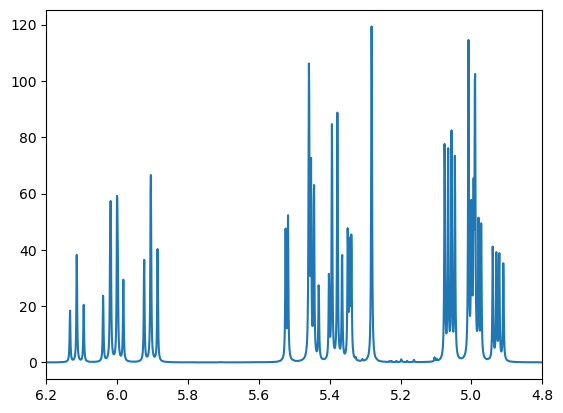

In [26]:
plt.plot(fs, spcOut, '-')
plt.xlim(6.2,4.8)